In [1]:
import sys
import os
import operator

from math import *
import inspect
import numpy as np
import pandas as pd
from copy import deepcopy
from matplotlib import pyplot as plt
import handcalcs.render
from handcalcs.decorator import handcalc
import forallpeople as si
from IPython.display import display, Latex
from PySide6.QtCore import Qt 
from PySide6.QtWidgets import QApplication, QInputDialog


sys.path.append(os.path.join(os.getcwd(), "catalog", "eurocode"))
import A0_Projet as A0
import A1_MEF as A1
import EC0_Combinaison as EC0
import EC5_Assemblage as EC5_Ass
import EC5_Element_droit as EC5_Ele

# N° projet - Projet - Note de calcul
---
## Élément :
- Annexe : ANxx
- Date : 03/10/2022
- Ingénieur : Anthony PARISOT
---

## 1. Paramètres
----

- <font color="blue" size ="5">**Vérifications**</font>

In [2]:
ELU_STR = True
ELU_STR_ACC = False
ELS = True

- <font color="blue" size ="5">**Chargement**</font>

In [3]:
Charge1 = [1, '', 'Permanente G', 'Linéique', -10, '0/4000', 'Z']
Charge2 = [0, 'Poids propre', 'Permanente G', 'Linéique', -50, '0/4000', 'Z']
Charge3 = [2, '', 'Neige normale Sn', 'Linéique', -200, '0/4000', 'Z']
Charge4 = [3, '', 'Exploitation Q', 'Linéique', -150, '0/4000', 'Z']

In [4]:
_list_loads = [Charge2, Charge3]
pd.DataFrame(_list_loads, columns=["Index", "Nom","Action","Type","Charge (daN ou daN/m)","Position (mm)","Axe"])

,Index,Nom,Action,Type,Charge (daN ou daN/m),Position (mm),Axe
0,0,Poids propre,Permanente G,Linéique,-50,0/4000,Z
1,2,,Neige normale Sn,Linéique,-200,0/4000,Z


- <font color="blue" size ="5">**Appuis**</font>

In [5]:
listdeplacement = [[1, "Rotule", 0, 40], [2, "Rotule", 4000, 40]]

In [6]:
pd.DataFrame(listdeplacement, columns=["Index","Type d'appuis","Position (mm)","Largeur d'appuis (mm)"])

,Index,Type d'appuis,Position (mm),Largeur d'appuis (mm)
0,1,Rotule,0,40
1,2,Rotule,4000,40


- <font color="blue" size ="5">**Dalle**</font>

In [7]:
app = QApplication()
disposition, ok = QInputDialog.getItem(
    None, "Position des planches", "Position des planches :", ["Latérale", "Dessus / Dessous"], 0, False, flags=Qt.FramelessWindowHint)

type_batiment, ok = QInputDialog.getItem(
    None, "Type de bâtiment", "Type de bâtiment :", ["Bâtiments courants", "Bâtiments agricoles et similaires"], 0, False, flags=Qt.FramelessWindowHint)

In [8]:
#recouvrement (int):Cela correspond à la distance entre le centre géométrique de la pièce 2 et celui de la pièce i. ATTENTION z local est vers le bas quand vous donnez le recouvrement.

In [9]:
%%render params 2
code_INSEE = 73215
alt = 1200 #m
type_element = "Élément structuraux"
longueur = 4000 * si.mm
disposition
classe_service = 1
humidite_initiale = 12 #pourcent
humidite_finale = 12 #pourcent
recouvrement = -40 #mm
entraxe_connecteurs = 200 #mm

<IPython.core.display.Latex object>

In [10]:
def calcs_number_node(long):
        """Retourne le nombre de d'élément pour le maillage MEF

        Returns:
            int: nombre d'élément MEF
        """
        round_long = ceil(long/10)*10
        
        if round_long <= 1000:
            ele = int(round_long/10)
        elif round_long <= 10000:
            ele = int(round_long/100)
        else:
            ele = int(round_long/200)
        return ele
    
node = 600
#node = calcs_number_node(longueur.value*10**3)

- <font color="blue" size ="5">**Planche basse**</font>

In [11]:
%%render params 2
b_planche_basse = 77 * si.mm
h_planche_basse = 360 * si.mm
classe_bois_planche_basse = "C24"


<IPython.core.display.Latex object>

In [12]:
projet = A0.Projet(code_INSEE=code_INSEE, alt= alt)
chargement = EC0.Chargement._from_parent_class(projet)
chargement.create_load_by_list(_list_loads)
barre2 = EC5_Ass.Barre._from_parent_class(projet, b=b_planche_basse.value*10**3, h=h_planche_basse.value*10**3, section="Rectangulaire", Hi=humidite_initiale, Hf=humidite_finale, classe=classe_bois_planche_basse, cs=classe_service, effet_systeme="False")
pd.DataFrame(barre2.caract_meca).T

,fm0k,ft0k,ft90k,fc0k,fc90k,fvk,E0mean,E005,E90mean,Gmoy,rhok,rhomean
C24,24,14.5,0.4,21,2.5,4,11000,7400,370,690,350,420


- <font color="blue" size ="5">**Planche haute**</font>

In [13]:
%%render params 2
b_planche_intermediaire = 83 * si.mm
h_planche_intermediaire = 120 * si.mm
classe_bois_planche_intermediaire = "C24"

<IPython.core.display.Latex object>

In [14]:
barre3 = EC5_Ass.Barre._from_parent_class(projet, b=b_planche_intermediaire.value*10**3, h=h_planche_intermediaire.value*10**3, section="Rectangulaire", Hi=humidite_initiale, Hf=humidite_finale, classe=classe_bois_planche_intermediaire, cs=classe_service, effet_systeme="False")
pd.DataFrame(barre3.caract_meca).T

,fm0k,ft0k,ft90k,fc0k,fc90k,fvk,E0mean,E005,E90mean,Gmoy,rhok,rhomean
C24,24,14.5,0.4,21,2.5,4,11000,7400,370,690,350,420


- <font color="blue" size ="5">**Connecteurs**</font>

In [15]:
%%render params 2
d = 6 * si.mm
d1 = 3.9 * si.mm
ds = 4.3 * si.mm
dh = 12 * si.mm
l = 200 * si.mm
rho_a = 350 * si.kg / si.m**3
fhead = 10.5 * si.MPa
ftensk = 11300 * si.N
f_ax_k = 11.7 *si.MPa
MyRk = 9494 * si.N*si.mm
alpha1 = 90 #°
alpha2 = 90 #°

<IPython.core.display.Latex object>

In [16]:
assemblage = EC5_Ass.Assemblage._from_parent_class(projet, beam_1=barre3, beam_2=barre2, nfile=1, nCis=2)

#############   Vérification vis-boulon ou vis-pointe selon d_ef
if d1.value*10**3*1.1 > 6:
    connecteur = EC5_Ass.Tirefond_sup_6._from_parent_class(assemblage, d=d.value*10**3, d1=d1.value*10**3, ds=ds.value*10**3, dh=dh.value*10**3, l=l.value*10**3, n=1, rho_a=rho_a.value, fhead=fhead.value*10**-6, ftensk=ftensk.value, MyRk=MyRk.value*10**3, alpha1=alpha1, alpha2=alpha2)
else:
    connecteur = EC5_Ass.Tirefond_inf_7._from_parent_class(assemblage, d=d.value*10**3, d1=d1.value*10**3, ds=ds.value*10**3, dh=dh.value*10**3, l=l.value*10**3, n=1, rho_a=rho_a.value, fhead=fhead.value*10**-6, ftensk=ftensk.value, MyRk=MyRk.value*10**3, alpha1=alpha1, alpha2=alpha2, percage = True)


#############   Kser par vis et par plan de cisaillement
Kser = connecteur.Kser

#############   Kser assemblage
Kser_ass = connecteur.Kser_ass
dalle = EC5_Ele.Poutre_assemblee_meca(beam_2=barre2, l=longueur.value*10**3, disposition=disposition, recouvrement=[0,recouvrement], Kser=[None,None,Kser_ass[1]], entraxe=[None,None,entraxe_connecteurs], psy_2=0, beam_3=barre3)
combinaison = A1.Combinaison._from_parent_class(chargement, ELU_STR=ELU_STR, ELU_STR_ACC=ELU_STR_ACC, ELS_C=ELS, ELS_QP=ELS, cat="Cat A : habitation", kdef=dalle.K_def[1])

#############   Kser final tenant compte du fluage
Kser_fin = dalle.Kser_fin

#############   Portance locale
fh1k = connecteur.fh1k
fh2k = connecteur.fh2k

#############   Nombre efficace
nef = connecteur.nef(a1_beam1=entraxe_connecteurs, a1_beam2=entraxe_connecteurs)
connecteur.nfile

#############   Résistance axiale
FaxRk = connecteur.FaxRk(faxk=f_ax_k, l_ef=connecteur.t1, alpha=alpha1, beam=barre3)

#############   Capacité résistante caractéristique par tige et par plan de cisaillement
FvRk = connecteur.FvRk(True)

#############   Gamma i
gamma_i = dalle.gamma_i
gamma_2 = gamma_i["gamma 2"]
gamma_3 = gamma_i["gamma 3"][0]

#############   EI efficace dalle
ei_eff = dalle.EI_eff


l = int(ceil(dalle.l.value * 10**3))
E_mean_fin = int(barre2.E_mean_fin.value*10**-6)
A = barre2.b * barre2.h + barre3.b * barre3.h
A = A.value*10**6
iy = ei_eff[1].value*10**6 / E_mean_fin
G = float(barre2.caract_meca.Gmoy)



dict_combi = {}
dict_taux_max = {type_verif: {"combinaison": "", "taux": 0} for type_verif in ("cisaillement", "Winst(Q)", "Wnet,fin")}
dict_taux_max_flexion = {dim_barre:{"combinaison": "", "taux": 0} for dim_barre in ("planche basse", "planche intermédiaire")}
        
for i, barre in enumerate([barre2,barre3]):
    index_barre = i+2
    if i==0:
        dim_barre = "planche basse"
    else:
        dim_barre = "planche intermédiaire"
        
        
    for combi in combinaison.get_list_combination():
        combinaison.get_combi_list_load(combi)
        dict_combi[combi]= {}
        dict_combi[combi]["EF"] = A1.MEF._from_parent_class(combinaison, long=l, E=E_mean_fin, A=A, G=G, J=1, Iy=iy, Iz=1, ele=node, alphaZ=0, alphaY=0, alphaX=0)
        dict_combi[combi]["EF"].create_supports_by_list(listdeplacement)
        dict_combi[combi]["EF"].calcul_1D()
        
        if combi[0:7] == 'ELU_STR':
            action = dict_combi[combi]["EF"].min_type_load(combi)
            barre2.K_mod = barre2.K_mod_table[action].iloc[0]
            barre3.K_mod = barre3.K_mod_table[action].iloc[0]

            dictEiMinMax = dict_combi[combi]["EF"].effort_interne_max()
            max_XY_values = (dictEiMinMax["My_max"]["Position"], dictEiMinMax["My_max"]["Effort"])
            min_XY_values = (dictEiMinMax["My_min"]["Position"], dictEiMinMax["My_min"]["Effort"])
                
            dict_effort_max = dict_combi[combi]["EF"].effort_interne_max()
            V_z = max(dict_effort_max['Vz_max']['Effort'],abs(dict_effort_max['Vz_min']['Effort']))
            tau_2 = dalle.tau_2_max(V_z)

            M_y = max(dict_effort_max['My_max']['Effort'],abs(dict_effort_max['My_min']['Effort']))
            sigma_i = dalle.sigma_i(M_y, beam=index_barre)
            sigma_mi = dalle.sigma_mi(M_y, beam=index_barre)

            F_i = dalle.F_i(V_z, connecteur=2)

            dict_combi[combi]["flexion"] = EC5_Ele.Flexion._from_parent_class(barre, lo=longueur.value*10**3, coeflef=0.9, pos="Charge sur fibre comprimée")
            dict_combi[combi]["flexion"].sigma_m_rd = {'y': sigma_mi[1], 'z': 0 * si.MPa}
            fmd = dict_combi[combi]["flexion"].f_m_d(action, "Fondamentales")

            if sigma_i[1] < 0:
                dict_combi[combi]["compression"] = EC5_Ele.Compression._from_parent_class(barre,  lo_y=longueur.value*10**3, lo_z=longueur.value*10**3, type_appuis= "Rotule - Rotule")
                fc0d = dict_combi[combi]["compression"].f_c_0_d(action, "Fondamentales")
                dict_combi[combi]["compression"].sigma_c_0_rd = abs(sigma_i[1])
                taux_compression = dict_combi[combi]["compression"].taux_c_0_d()
                compression=dict_combi[combi]["compression"]
                traction=None
            else:
                dict_combi[combi]["traction"] = EC5_Ele.Traction._from_parent_class(barre)
                ft0d = dict_combi[combi]["traction"].f_t_0_d(action, "Fondamentales")
                dict_combi[combi]["traction"].sigma_t_0_rd = sigma_i[1]
                taux_traction = dict_combi[combi]["traction"].taux_t_0_d()
                traction=dict_combi[combi]["traction"]
                compression=None
                
            taux_flexion = dict_combi[combi]["flexion"].taux_m_d(compression=compression, traction=traction)    
            dict_combi[combi]["cisaillement"] = EC5_Ele.Cisaillement._from_parent_class(barre)
            dict_combi[combi]["cisaillement"].tau_rd = tau_2[1]
            fmd = dict_combi[combi]["cisaillement"].f_v_d(action, "Fondamentales")
            taux_cisaillement = dict_combi[combi]["cisaillement"].taux_tau_d()
            
            
            
            dict_taux_flexion = dict_combi[combi]["flexion"].taux_m_rd
            max_taux_flexion = max(dict_taux_flexion.items(), key=operator.itemgetter(1))[1]
            
            if max_taux_flexion > dict_taux_max_flexion[dim_barre]["taux"]:
                dict_taux_max_flexion[dim_barre]["combinaison"] = combi
                dict_taux_max_flexion[dim_barre]["taux"] = max_taux_flexion
            
            dict_taux_cisaillement = dict_combi[combi]["cisaillement"].taux_tau_rd
            max_taux_cisaillement = max(dict_taux_cisaillement.items(), key=operator.itemgetter(1))[1]
            
            if max_taux_cisaillement > dict_taux_max["cisaillement"]["taux"]:
                dict_taux_max["cisaillement"]["combinaison"] = combi
                dict_taux_max["cisaillement"]["taux"] = max_taux_cisaillement
                
        elif combi[0:6] == 'W_inst':
            dictUMinMax = dict_combi[combi]["EF"].deplacement_max()
            max_XY_values = (dictUMinMax["Uz_max"][0], dictUMinMax["Uz_max"][1])
            min_XY_values = (dictUMinMax["Uz_min"][0], dictUMinMax["Uz_min"][1])
            
            fleche_max = max(dictUMinMax['Uz_max'][0],abs(dictUMinMax['Uz_min'][1]))
            barre.fleche(long=l, Ed_WinstQ=fleche_max, type_ele=type_element, type_bat=type_batiment)
            if barre.taux_ELS["Winst(Q)"] > dict_taux_max["Winst(Q)"]["taux"]:
                dict_taux_max["Winst(Q)"]["combinaison"] = combi
                dict_taux_max["Winst(Q)"]["taux"] = barre.taux_ELS["Winst(Q)"]
        
        elif combi[0:9] == 'W_net_fin':
            dictUMinMax = dict_combi[combi]["EF"].deplacement_max()
            max_XY_values = (dictUMinMax["Uz_max"][0], dictUMinMax["Uz_max"][1])
            min_XY_values = (dictUMinMax["Uz_min"][0], dictUMinMax["Uz_min"][1])
            
            fleche_max = max(dictUMinMax['Uz_max'][0],abs(dictUMinMax['Uz_min'][1]))
            barre.fleche(long=l, Ed_Wnetfin=fleche_max, type_ele=type_element, type_bat=type_batiment)
            if barre.taux_ELS["Wnet,fin"] > dict_taux_max["Wnet,fin"]["taux"]:
                dict_taux_max["Wnet,fin"]["combinaison"] = combi
                dict_taux_max["Wnet,fin"]["taux"] = barre.taux_ELS["Wnet,fin"]
                
Fv_Rd = connecteur.F_Rd(FvRk[1].value*10**-3)
Taux_connecteur = connecteur.taux_cisaillement(Fv_Ed = F_i[1].value*10**-3)

c:\Users\mamessier\Desktop\Projet python\ECOTIM_Catalogue eurocode\Eurocode\catalog\eurocode\EC0_Combinaison.py:580: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df_W_inst_Q.iloc[index,0] = name_combi


1512.0


## 3. Combinaisons d'action
---

In [17]:
pd.DataFrame(combinaison.list_combination)

,Combinaison
0,ELS_C G
1,ELS_C G + Sn
2,ELS_QP G
3,ELS_QP G + 0.2Sn
4,ELU_STR 1.35G
5,ELU_STR 1.35G + 1.5Sn
6,ELU_STR G
7,ELU_STR Sn
8,W_inst Sn
9,W_net_fin ELS_C G & ELS_QP G


## 4. Assemblage
----

- <font color="blue" size ="5">**Kser par vis et par plan de cisaillement**</font>

In [18]:
display(Latex(Kser[0]))

<IPython.core.display.Latex object>

- <font color="blue" size ="5">**Kser assemblage**</font>

In [19]:
display(Latex(Kser_ass[0]))

<IPython.core.display.Latex object>

- <font color="blue" size ="5">**Kser final tenant compte du fluage**</font>

In [20]:
display(Latex(Kser_fin["Kser fin 2-3"][0]))

<IPython.core.display.Latex object>

In [21]:
display(Latex(fh1k[0]))

display(Latex(fh2k[0]))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [22]:
display(Latex(nef[0]))

<IPython.core.display.Latex object>

In [23]:
connecteur.nfile

1

In [24]:
display(Latex(FvRk[0]))

<IPython.core.display.Latex object>

## 5. Rigidité efficace de la poutre assemblée mécaniquement
----

- <font color="blue" size ="5">**Gamma, facteur de glissement des connecteurs**</font>

In [25]:
display(Latex(gamma_3))

<IPython.core.display.Latex object>

In [26]:
%%render params 0

gamma_2

<IPython.core.display.Latex object>

- <font color="blue" size ="5">**Distance de l'axe de la pièce par rapport à l'axe neutre de l'assemblage**</font>

In [27]:
data = {"Planche":["Planche basse","Planche intermédiaire"],
        "Distance à l'axe neutre":[dalle.distance_ai[1],dalle.distance_ai[2]]}
distanceai = pd.DataFrame(data)
distanceai

,Planche,Distance à l'axe neutre
0,Planche basse,2.581 mm
1,Planche intermédiaire,-37.419 mm


- <font color="blue" size ="5">**Rigidité efficace en flexion**</font>

In [28]:
display(Latex(ei_eff[0]))


<IPython.core.display.Latex object>

## 6. Cisaillement
----

- <font color="blue" size ="5">**Diagramme des efforts tranchants Vz**</font>

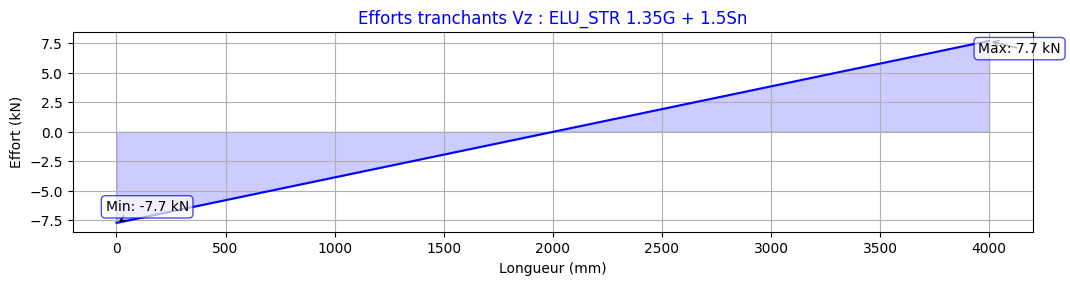

In [29]:
combi = dict_taux_max["cisaillement"]["combinaison"]
dict_combi[combi]["EF"].show_graphique_Vz(combi)

- <font color="blue" size ="5">**Contrainte de cisaillement maximale dans l'élément 2 selon Annexe B.4 de l'EN 1995**</font>

In [30]:
dict_effort_max = dict_combi[combi]["EF"].effort_interne_max()
V_z = max(dict_effort_max['Vz_max']['Effort'],abs(dict_effort_max['Vz_min']['Effort']))
tau_2 = dalle.tau_2_max(V_z)
display(Latex(tau_2[0]))

<IPython.core.display.Latex object>

- <font color="blue" size ="5">**Capacité résistante en cisaillement de l'élément 2**</font>

In [31]:
fmd = dict_combi[combi]["cisaillement"].f_v_d(action, "Fondamentales")
display(Latex(fmd[0]))

<IPython.core.display.Latex object>

- <font color="blue" size ="5">**Taux de travail en cisaillement maximal dans l'élément 2**</font>

In [32]:
taux_cisaillement = dict_combi[combi]["cisaillement"].taux_tau_d()
display(Latex(taux_cisaillement[0]))

<IPython.core.display.Latex object>

## 7. Flexion selon l'axe y
----

#### 7.1. Flexion dans la planche basse selon l'axe y

- <font color="blue" size ="5">**Diagramme du moment My**</font>

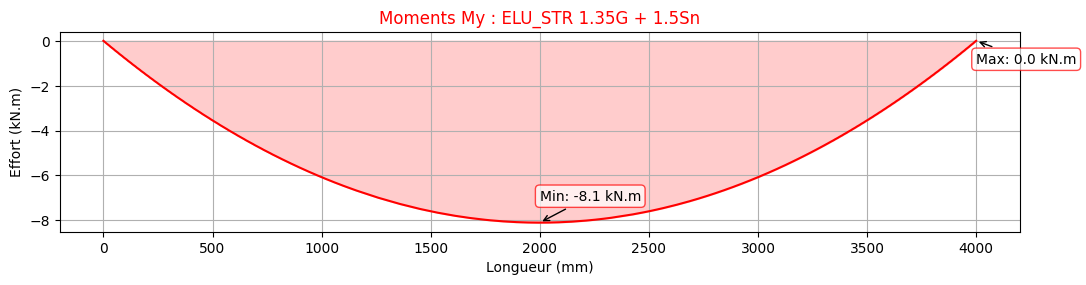

In [33]:
combi = dict_taux_max_flexion["planche basse"]["combinaison"]
dict_combi[combi]["EF"].show_graphique_My(combi)

- <font color="blue" size ="5">**Contrainte de flexion le long de l'axe y selon Annexe B.3 de l'EN 1995**</font>

In [34]:
dict_effort_max = dict_combi[combi]["EF"].effort_interne_max()
M_y = max(dict_effort_max['My_max']['Effort'],abs(dict_effort_max['My_min']['Effort']))
sigma_mi = dalle.sigma_mi(M_y, beam=2)

display(Latex(sigma_mi[0]))

<IPython.core.display.Latex object>

- <font color="blue" size ="5">**Résistance de calcul en flexion**</font>

In [35]:
fmd = dict_combi[combi]["flexion"].f_m_d(action, "Fondamentales")
display(Latex(fmd[0]))

<IPython.core.display.Latex object>

- <font color="blue" size ="5">**Taux de travail en flexion**</font>

In [36]:
sigma_i = dalle.sigma_i(M_y, beam=2)
display(Latex(sigma_i[0]))

<IPython.core.display.Latex object>

In [37]:
barre=barre2
dict_combi[combi]["flexion"].sigma_m_rd = {'y': sigma_mi[1], 'z': 0 * si.MPa}
if sigma_i[1] < 0:
    dict_combi[combi]["compression"] = EC5_Ele.Compression._from_parent_class(barre,  lo_y=longueur.value*10**3, lo_z=longueur.value*10**3, type_appuis= "Rotule - Rotule")
    fc0d = dict_combi[combi]["compression"].f_c_0_d(action, "Fondamentales")
    dict_combi[combi]["compression"].sigma_c_0_rd = abs(sigma_i[1])
    taux_compression = dict_combi[combi]["compression"].taux_c_0_d()
    compression=dict_combi[combi]["compression"]
    traction=None
else:
    dict_combi[combi]["traction"] = EC5_Ele.Traction._from_parent_class(barre)
    ft0d = dict_combi[combi]["traction"].f_t_0_d(action, "Fondamentales")
    dict_combi[combi]["traction"].sigma_t_0_rd = sigma_i[1]
    taux_traction = dict_combi[combi]["traction"].taux_t_0_d()
    traction=dict_combi[combi]["traction"]
    compression=None
taux_flexion = dict_combi[combi]["flexion"].taux_m_d(compression=compression, traction=traction)
display(Latex(taux_traction[0]))

<IPython.core.display.Latex object>

In [38]:
display(Latex(taux_flexion[0]))

<IPython.core.display.Latex object>

#### 7.2. Flexion dans la planche intermédiaire selon l'axe y

- <font color="blue" size ="5">**Diagramme du moment My**</font>

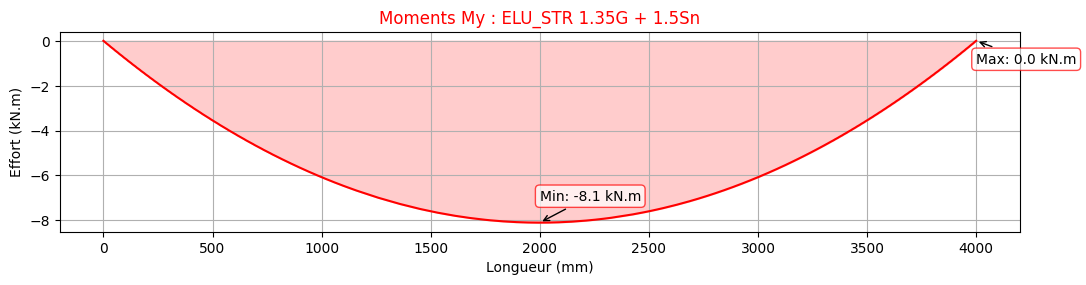

In [39]:
combi = dict_taux_max_flexion["planche intermédiaire"]["combinaison"]
dict_combi[combi]["EF"].show_graphique_My(combi)

- <font color="blue" size ="5">**Contrainte de flexion le long de l'axe y selon Annexe B.3 de l'EN 1995**</font>

In [40]:
dict_effort_max = dict_combi[combi]["EF"].effort_interne_max()
M_y = max(dict_effort_max['My_max']['Effort'],abs(dict_effort_max['My_min']['Effort']))
sigma_mi = dalle.sigma_mi(M_y, beam=3)
display(Latex(sigma_mi[0]))

<IPython.core.display.Latex object>

- <font color="blue" size ="5">**Résistance de calcul en flexion**</font>

In [41]:
fmd = dict_combi[combi]["flexion"].f_m_d(action, "Fondamentales")
display(Latex(fmd[0]))

<IPython.core.display.Latex object>

- <font color="blue" size ="5">**Taux de travail en flexion**</font>

In [42]:
taux_flexion = dict_combi[combi]["flexion"].taux_m_d(compression=dict_combi[combi]["compression"])
display(Latex(taux_flexion[0]))

<IPython.core.display.Latex object>

## 8. Flèche instantanée (Q)
----

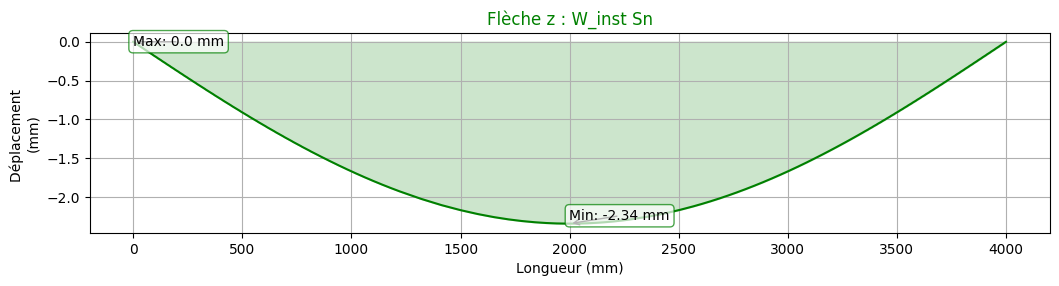

In [43]:
dict_combi[dict_taux_max["Winst(Q)"]["combinaison"]]["EF"].show_graphique_fleche(dict_taux_max["Winst(Q)"]["combinaison"])

## 9. Flèche nette finale
----

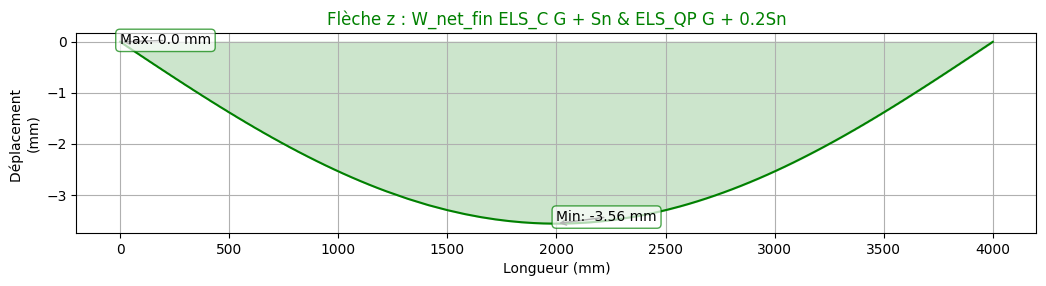

In [44]:
dict_combi[dict_taux_max["Wnet,fin"]["combinaison"]]["EF"].show_graphique_fleche(dict_taux_max["Wnet,fin"]["combinaison"])

## 9. Tableau récapitulatif des efforts internes
----

In [45]:
df = pd.DataFrame(dict_combi[combi]["EF"].effort_interne_max())
df

,Nx_max,Nx_min,Vz_max,Vz_min,My_max,My_min
Position,0.000000,4000.000000,4000.000000,0.000000,4.000000e+03,2000.000000
Effort,0.000466,-0.000469,7.703329,-7.703337,3.242493e-11,-8.101634


## 11. Contrainte de compression parallèle au fil selon Annexe B.3 de l'EN 1995
----

In [46]:
display(Latex(sigma_i[0]))

<IPython.core.display.Latex object>

In [47]:
display(Latex(sigma_mi[0]))

<IPython.core.display.Latex object>

## 13. Charge à reprendre par organe d'assemblage selon Annexe B.5 de l'EN 1995
----

In [48]:
display(Latex(F_i[0]))

<IPython.core.display.Latex object>

- <font color="blue" size ="5">**Taux de travail connecteur**</font>

In [49]:
Fv_Rd = connecteur.F_Rd(FvRk[1].value*10**-3)
display(Latex(Fv_Rd[0]))

<IPython.core.display.Latex object>

In [50]:
Taux_connecteur = connecteur.taux_cisaillement(Fv_Ed = F_i[1].value*10**-3)
display(Latex(Taux_connecteur[0]))

<IPython.core.display.Latex object>

In [51]:
app.exit()

In [52]:
# yG = dalle.distance_ai[1] + barre2.h_calcul/2
# yG = yG.value *10**3
# y = [h for h in range(0, int(barre2.h_calcul.value*10**3)+20, 20)]

# sigma_m = []
# tau = []
# My = M_y.value*10**3
# Vz = V_z.value
# E_mean_fin_3 = dalle.beam[2].E_mean_fin.value *10**-6
# ei_eff = dalle.EI_eff[1].value *10**6
# beam_2 = dalle.beam[1]
# beam_3 = dalle.beam[2]
# h3 = (dalle.beam[1].h_calcul.value/2 - dalle.recouvrement[1].value- dalle.beam[2].h_calcul.value/2)*10**3
# print(h3, dalle.beam[1].h_calcul.value, dalle.recouvrement[1].value, dalle.beam[2].h_calcul.value)

# tau_value = 0
# for h in y:
#     for yi in y:
#         for index, beam in enumerate(dalle.beam):
#             if beam_2.h_calcul.value *10**3 <=yi:
#                 if beam is not None:
#                     gamma_i = dalle.gamma_i["gamma 2"]
#                     E_mean_fin = beam_2.E_mean_fin.value *10**-6
#                     b = dalle.beam[1].b_calcul.value *10**3
#                     h = dalle.beam[1].h_calcul.value *10**3
#                     distance_ai = dalle.distance_ai[1].value *10**3
#                     h_z = h
#                     for yi in y:
#                         if yi < h:
#                             h_z = yi
#                         else:
#                             h_z = h
                        
#                         tau_2 = (Vz*gamma_i*E_mean_fin*b*h_z*distance_ai)/(ei_eff*b) 
#                         tau_value = tau_value + tau_2
#                         print (tau_value, h_z, gamma_i)
#             elif h3 <=yi:
#                 if beam is not None:
#                     gamma_i = dalle.gamma_i["gamma 3"][1]
#                     print(gamma_i)
#                     E_mean_fin = beam_3.E_mean_fin.value *10**-6
#                     b = dalle.beam[2].b_calcul.value *10**3
#                     h = dalle.beam[2].h_calcul.value *10**3
#                     distance_ai = dalle.distance_ai[2].value *10**3
#                     h_z = h+h3
#                     for yi in y:
#                         if yi < h_z:
#                             h_z = yi
#                         else:
#                             h_z = h_z
#                         print(Vz,gamma_i,E_mean_fin,b,h_z,distance_ai,ei_eff,b)
#                         tau_3 = (Vz*gamma_i*E_mean_fin*b*h_z*distance_ai)/(ei_eff*b) 
#                         tau_value = tau_value + tau_3
#                         print (tau_value, h_z, gamma_i)
#     tau.append(tau_value)
        
# for h in y:
#     v = yG - h
#     sigma_m.append(My * E_mean_fin_3 * v / ei_eff)

# plt.figure(figsize=(14,7))
# plt.title("Contrainte de flexion Sigma,m")
# plt.xlabel("Contrainte en MPa")
# plt.ylabel("Hauteur de la poutre en mm")

# plt.plot(sigma_m, y)
# plt.plot(tau, y)

# plt.plot([0] * len(y), y, color='red')
# x = np.arange(int(min(sigma_m))-10, int(max(sigma_m))+10, step=2)
# plt.plot(x, [yG] * len(x), color='red')

# plt.grid(True)
# plt.xticks(np.arange(int(min(sigma_m))-5, int(max(sigma_m))+5, step=2))
# plt.yticks(np.arange(int(min(y)), int(max(y)+10), step=10))

# if abs(int(min(sigma_m))) > abs(int(max(sigma_m))):
#     sigma_max  = round(min(sigma_m),2)
# else:
#     sigma_max = round(max(sigma_m),2)
# if abs(int(min(tau))) > abs(int(max(tau))):
#     tau_max  = round(min(tau),2)
# else:
#     tau_max = round(max(tau),2)
# plt.text(sigma_max, int(yG) +10, f"yG: {round(yG,1)}mm", color="red")
# plt.text(sigma_max, int(barre2.h_calcul.value*10**3 / 2 - 50), f"contrainte max flexion: \n{sigma_max} MPa", color="blue")
# plt.text(tau_max, int(barre2.h_calcul.value*10**3 / 2 - 50), f"contrainte max cisaillement : \n{tau_max} MPa", color="orange")
# plt.show()